In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio import EcgBatch
from cardio.dataset import F, V, B
from cardio.models.fft_model import FFTModel

%env CUDA_VISIBLE_DEVICES=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

env: CUDA_VISIBLE_DEVICES=1


Using TensorFlow backend.


## Train pipeline

In [2]:
model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape),
    "loss": "binary_crossentropy",
    "optimizer": "adam"
}

def make_data(batch, **kwagrs):
    return {'x': np.array(list(batch.signal)), 'y': batch.target}
    
train_pipeline = (ds.Pipeline()
                  .init_model("dynamic", FFTModel, name="fft_model", config=model_config)
                  .init_variable("loss_history", init=list)
                  .load(fmt="wfdb", components=["signal", "meta"])
                  .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                        fmt="csv", components="target")
                  .drop_labels(["~"])
                  .rename_labels({"N": "NO", "O": "NO"})
                  .random_resample_signals("normal", loc=300, scale=10)
                  .drop_short_signals(4000)
                  .split_signals(3000, 3000)
                  .binarize_labels()
                  .apply_transform(np.transpose, axes=[0, 2, 1], src='signal', dst='signal')
                  .unstack_signals()
                  .train_model('fft_model', make_data=make_data,
                               save_to=V("loss_history"), mode="a"))

In [3]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=EcgBatch)
eds.cv_split(0.8)

In [4]:
fft_trained = (eds.train >> train_pipeline).run(batch_size=300, shuffle=True,
                                                drop_last=True, n_epochs=150, prefetch=0)

## Show loss and metric on train

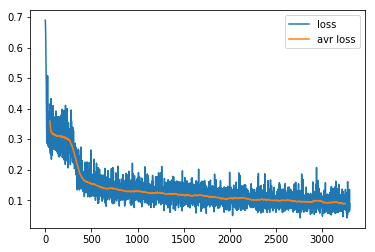

In [5]:
import pandas as pd
loss = pd.DataFrame(fft_trained.get_variable("loss_history"), columns=["loss"])
loss["avr loss"] = pd.DataFrame(loss).rolling(center=True, window=100).mean()
loss.plot()
plt.show()

## Save model

In [6]:
from cardio.models.keras_custom_objects import RFFT, Crop, Inception2D
(fft_trained.get_model_by_name("fft_model")
            .save("/notebooks/e_illarionov/ecg_repo/model_dump/fft_latest"))

## Test pipeline

In [7]:
def make_pivot(pipeline, variable_name):
    cropes = np.array([x[0] for x in pipeline.get_variable("shapes")])
    pos = np.vstack([np.pad(np.cumsum(cropes)[:-1], pad_width=(1, 0), mode='constant'), cropes]).T
    labels = np.array(pipeline.get_variable(variable_name))    
    return np.array([labels[s: s + i].mean(axis=0) for s, i in pos])

test_pipeline = (ds.Pipeline()
                 .import_model("fft_model", fft_trained)
                 .init_variable("true_labels", init=list)
                 .init_variable("pred_labels", init=list)
                 .init_variable("shapes", init=list)
                 .init_variable("pivot_true_labels", init=list)
                 .init_variable("pivot_pred_labels", init=list)
                 .load(fmt="wfdb", components=["signal", "meta"])
                 .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                       fmt="csv", components="target")
                 .drop_labels(["~"])
                 .rename_labels({"N": "NO", "O": "NO"})
                 .drop_short_signals(4000)
                 .split_signals(3000, 3000)
                 .binarize_labels()
                 .apply_transform(np.transpose, axes=[0, 2, 1], src='signal', dst='signal')
                 .update_variable("shapes", F(lambda batch: [x.shape for x in batch.signal]), mode='w')
                 .unstack_signals()
                 .update_variable("true_labels", B('target'), mode='w')
                 .predict_model('fft_model', make_data=make_data, save_to=V("pred_labels"), mode="w")
                 .update_variable("pivot_true_labels", F(lambda batch: make_pivot(batch.pipeline, 'true_labels')), mode='e')
                 .update_variable("pivot_pred_labels", F(lambda batch: make_pivot(batch.pipeline, 'pred_labels')), mode='e'))

In [8]:
res_test = (eds.test >> test_pipeline).run(batch_size=300, shuffle=False, drop_last=False,
                                           n_epochs=1, prefetch=0)

In [9]:
print(f1_score(np.array(res_test.get_variable("pivot_true_labels"))[:, 0],
               np.rint(res_test.get_variable("pivot_pred_labels"))[:, 0], average='macro'))

0.878696268304


In [10]:
from sklearn.metrics import classification_report
print(classification_report(np.array(res_test.get_variable("pivot_true_labels"))[:, 0],
                            np.rint(res_test.get_variable("pivot_pred_labels"))[:, 0]))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1443
        1.0       0.88      0.70      0.78       162

avg / total       0.96      0.96      0.96      1605

